# Proyek Analisis Sentimen Aplikasi By.U - Pemodelan

**Analisis Sentimen Aplikasi By.U** merupakan sebuah proyek yang bertujuan untuk mengumpulkan dan menganalisis ulasan pengguna terhadap aplikasi By.U yang tersedia di platform digital, seperti Google Play Store atau media sosial.

Melalui teknik web scraping dan pemrosesan teks, proyek ini berfokus pada pengelompokan komentar menjadi sentimen positif, negatif, atau netral guna mengetahui persepsi publik terhadap kualitas layanan, fitur aplikasi, dan pengalaman pengguna. Hasil analisis ini diharapkan dapat menjadi masukan berharga untuk pengembangan dan peningkatan layanan aplikasi By.U.

## Import Library

In [1]:
import pandas as pd  # Pandas untuk manipulasi dan analisis data
pd.options.mode.chained_assignment = None  # Menonaktifkan peringatan chaining
import numpy as np  # NumPy untuk komputasi numerik
seed = 0
np.random.seed(seed)  # Mengatur seed untuk reproduktibilitas
import matplotlib.pyplot as plt  # Matplotlib untuk visualisasi data
import seaborn as sns  # Seaborn untuk visualisasi data statistik, mengatur gaya visualisasi
from sklearn.metrics import accuracy_score

import datetime as dt  # Manipulasi data waktu dan tanggal
import re  # Modul untuk bekerja dengan ekspresi reguler
import string  # Berisi konstanta string, seperti tanda baca
from nltk.tokenize import word_tokenize  # Tokenisasi teks
from nltk.corpus import stopwords  # Daftar kata-kata berhenti dalam teks

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Stemming (penghilangan imbuhan kata) dalam bahasa Indonesia
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Menghapus kata-kata berhenti dalam bahasa Indonesia

from wordcloud import WordCloud  # Membuat visualisasi berbentuk awan kata (word cloud) dari teks

import nltk  # Import pustaka NLTK (Natural Language Toolkit).
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.9 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Loading Dataset

Data yang digunakan adalah data hasil scrapping aplikasi By.U di playstore

In [2]:
app_reviews_df = pd.read_csv('ulasan_aplikasi_byu.csv')

In [3]:
app_reviews_df.head()

,Review
0,"Aplikasinya sebenarnya bagus, banyak pilihan k..."
1,"aku pengguna lama by.u, tapi kok lama kelamaan..."
2,untuk jaringan by.u nya sih bagus cuman kalau ...
3,"Makin kesini byu makin ga bagus,aplikasi serin..."
4,pake by u lumayan lama tapi sampe sekarang bel...


## Data Understanding

In [4]:
# Menampilkan informasi tentang DataFrame app_reviews_df
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166856 entries, 0 to 166855
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Review  166854 non-null  object
dtypes: object(1)
memory usage: 1.3+ MB


Mengecek Missing Value

In [8]:
app_reviews_df.isnull().sum()

,0
Review,2


In [9]:
# Membuat DataFrame baru (clean_df) dengan menghapus baris yang memiliki nilai yang hilang (NaN) dari app_reviews_df
clean_df = app_reviews_df.dropna()

Memeriksa kembali missing value

In [10]:
clean_df.isnull().sum()

,0
Review,0


Mengecek Data Duplikat

In [11]:
duplikat = clean_df.duplicated()
print(duplikat.sum())

45131


Mengatasi Data Duplikat

In [12]:
clean_df = clean_df.drop_duplicates()

In [13]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 121723 entries, 0 to 166854
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Review  121723 non-null  object
dtypes: object(1)
memory usage: 1.9+ MB


## Text Preprocessing

Membuat fungsi teknik pemrosesan teks

In [14]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

Membuat fungsi slangwords

In [16]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

Mengaplikasikan fungsi pemrosesan teks

In [19]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [20]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['Review'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [21]:
clean_df.head()

,Review,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,"Aplikasinya sebenarnya bagus, banyak pilihan k...",Aplikasinya sebenarnya bagus banyak pilihan ku...,aplikasinya sebenarnya bagus banyak pilihan ku...,aplikasinya sebenarnya bagus banyak pilihan ku...,"[aplikasinya, sebenarnya, bagus, banyak, pilih...","[aplikasinya, bagus, pilihan, kuota, menarik, ...",aplikasinya bagus pilihan kuota menarik minusn...
1,"aku pengguna lama by.u, tapi kok lama kelamaan...",aku pengguna lama byu tapi kok lama kelamaan a...,aku pengguna lama byu tapi kok lama kelamaan a...,aku pengguna lama byu tapi kok lama kelamaan a...,"[aku, pengguna, lama, byu, tapi, kok, lama, ke...","[pengguna, byu, ngerasa, byu, jaringannya, sta...",pengguna byu ngerasa byu jaringannya stabil ka...
2,untuk jaringan by.u nya sih bagus cuman kalau ...,untuk jaringan byu nya sih bagus cuman kalau u...,untuk jaringan byu nya sih bagus cuman kalau u...,untuk jaringan byu nya sih bagus cuman kalau u...,"[untuk, jaringan, byu, nya, sih, bagus, cuman,...","[jaringan, byu, bagus, cuman, diaplikasi, kend...",jaringan byu bagus cuman diaplikasi kendor tra...
3,"Makin kesini byu makin ga bagus,aplikasi serin...",Makin kesini byu makin ga bagusaplikasi sering...,makin kesini byu makin ga bagusaplikasi sering...,makin kesini byu makin ga bagusaplikasi sering...,"[makin, kesini, byu, makin, ga, bagusaplikasi,...","[kesini, byu, bagusaplikasi, bukakomplain, res...",kesini byu bagusaplikasi bukakomplain respon l...
4,pake by u lumayan lama tapi sampe sekarang bel...,pake by u lumayan lama tapi sampe sekarang bel...,pake by u lumayan lama tapi sampe sekarang bel...,pake by u lumayan lama tapi sampe sekarang bel...,"[pake, by, u, lumayan, lama, tapi, sampe, seka...","[pake, u, lumayan, sampe, peningkatan, jaringa...",pake u lumayan sampe peningkatan jaringan aja ...


## Pelabelan Teks

In [22]:
import csv
import requests
from io import StringIO

# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

Membuat fungsi untuk menghitung polaritas

In [23]:
def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:

    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''
    # Inisialisasi variabel polaritas

    if (score >= 0):
        polarity = 'positive'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negative'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif

    # else:
    #     polarity = 'neutral'
    # Ini adalah bagian yang bisa digunakan untuk menentukan polaritas netral jika diperlukan

    return score, polarity
    # Mengembalikan skor sentimen dan polaritas teks

Mengaplikasikan fungsi pelabelan teks

In [24]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    62938
negative    58785
Name: count, dtype: int64


In [25]:
clean_df.head()

,Review,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
0,"Aplikasinya sebenarnya bagus, banyak pilihan k...",Aplikasinya sebenarnya bagus banyak pilihan ku...,aplikasinya sebenarnya bagus banyak pilihan ku...,aplikasinya sebenarnya bagus banyak pilihan ku...,"[aplikasinya, sebenarnya, bagus, banyak, pilih...","[aplikasinya, bagus, pilihan, kuota, menarik, ...",aplikasinya bagus pilihan kuota menarik minusn...,8,positive
1,"aku pengguna lama by.u, tapi kok lama kelamaan...",aku pengguna lama byu tapi kok lama kelamaan a...,aku pengguna lama byu tapi kok lama kelamaan a...,aku pengguna lama byu tapi kok lama kelamaan a...,"[aku, pengguna, lama, byu, tapi, kok, lama, ke...","[pengguna, byu, ngerasa, byu, jaringannya, sta...",pengguna byu ngerasa byu jaringannya stabil ka...,-1,negative
2,untuk jaringan by.u nya sih bagus cuman kalau ...,untuk jaringan byu nya sih bagus cuman kalau u...,untuk jaringan byu nya sih bagus cuman kalau u...,untuk jaringan byu nya sih bagus cuman kalau u...,"[untuk, jaringan, byu, nya, sih, bagus, cuman,...","[jaringan, byu, bagus, cuman, diaplikasi, kend...",jaringan byu bagus cuman diaplikasi kendor tra...,-15,negative
3,"Makin kesini byu makin ga bagus,aplikasi serin...",Makin kesini byu makin ga bagusaplikasi sering...,makin kesini byu makin ga bagusaplikasi sering...,makin kesini byu makin ga bagusaplikasi sering...,"[makin, kesini, byu, makin, ga, bagusaplikasi,...","[kesini, byu, bagusaplikasi, bukakomplain, res...",kesini byu bagusaplikasi bukakomplain respon l...,-18,negative
4,pake by u lumayan lama tapi sampe sekarang bel...,pake by u lumayan lama tapi sampe sekarang bel...,pake by u lumayan lama tapi sampe sekarang bel...,pake by u lumayan lama tapi sampe sekarang bel...,"[pake, by, u, lumayan, lama, tapi, sampe, seka...","[pake, u, lumayan, sampe, peningkatan, jaringa...",pake u lumayan sampe peningkatan jaringan aja ...,31,positive


Memvisualisasikan hasil pelabelan teks

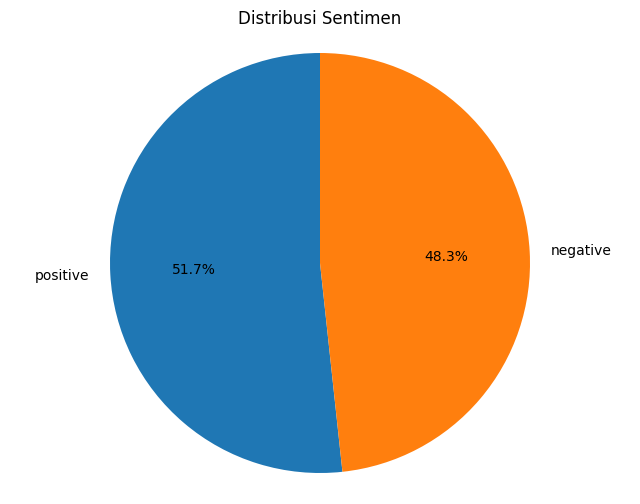

In [26]:
jumlah_sentimen = clean_df['polarity'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(jumlah_sentimen, labels=jumlah_sentimen.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Sentimen')
plt.axis('equal')
plt.show()

## Ekstraksi Fitur

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

Memisahkan fitur X dan Y

In [30]:
X = clean_df['text_akhir']
y = clean_df['polarity']

Ekstraksi Fitur dengan TF-IDF

In [31]:
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)

In [32]:
# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df


,aja,aktif,aktivasi,aman,aneh,apk,aplikasi,aplikasinya,app,bagus,...,trus,udah,udh,ulang,unlimited,update,via,wifi,yg,youtube
0,0.238514,0.0,0.0,0.000000,0.0,0.0,0.000000,0.155342,0.0,0.118439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.00000
1,0.157947,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.166997,0.00000
2,0.000000,0.0,0.0,0.374332,0.0,0.0,0.421154,0.000000,0.0,0.216645,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.00000
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.288894,0.000000,0.0,0.099073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.16875,0.000000,0.00000
4,0.117006,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.116204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.19898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121718,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.00000
121719,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.00000
121720,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.00000
121721,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.00000


## Pembagian Data

In [33]:
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

## Modeling

Pada proyek ini kita menggunakan model :  
1. Naive Bayes
2. Random Forest
3. Logistic Regression
4. Decision Tree

### Model Naive Bayes

In [34]:
from sklearn.naive_bayes import BernoulliNB

# Membuat objek model Naive Bayes (Bernoulli Naive Bayes)
naive_bayes = BernoulliNB()

# Melatih model Naive Bayes pada data pelatihan
naive_bayes.fit(X_train.toarray(), y_train)

BernoulliNB()

### Model Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

# Membuat objek model Random Forest
random_forest = RandomForestClassifier()

# Melatih model Random Forest pada data pelatihan
random_forest.fit(X_train.toarray(), y_train)

RandomForestClassifier()

### Model Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression()

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train.toarray(), y_train)

LogisticRegression()

### Model Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier

# Membuat objek model Decision Tree
decision_tree = DecisionTreeClassifier()

# Melatih model Decision Tree pada data pelatihan
decision_tree.fit(X_train.toarray(), y_train)

DecisionTreeClassifier()

## Evaluasi Model

### Hasil Evaluasi Model Naive Bayes

In [38]:
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_nb = naive_bayes.predict(X_train.toarray())
y_pred_test_nb = naive_bayes.predict(X_test.toarray())

# Evaluasi akurasi model Naive Bayes
accuracy_train_nb = accuracy_score(y_pred_train_nb, y_train)
accuracy_test_nb = accuracy_score(y_pred_test_nb, y_test)

# Menampilkan akurasi
print('Naive Bayes - accuracy_train:', accuracy_train_nb)
print('Naive Bayes - accuracy_test:', accuracy_test_nb)

Naive Bayes - accuracy_train: 0.783667768900573
Naive Bayes - accuracy_test: 0.7837749024440337


### Hasil Evaluasi Model Random Forest

In [39]:
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = random_forest.predict(X_train.toarray())
y_pred_test_rf = random_forest.predict(X_test.toarray())

# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)

# Menampilkan akurasi
print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.9624042391505269
Random Forest - accuracy_test: 0.8621482850688026


### Hasil Evaluasi Model Logistic Regression

In [40]:
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.8835876686725954
Logistic Regression - accuracy_test: 0.8824810022591908


### Hasil Evaluasi Model Decision Tree

In [41]:
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_dt = decision_tree.predict(X_train.toarray())
y_pred_test_dt = decision_tree.predict(X_test.toarray())

# Evaluasi akurasi model Decision Tree
accuracy_train_dt = accuracy_score(y_pred_train_dt, y_train)
accuracy_test_dt = accuracy_score(y_pred_test_dt, y_test)

# Menampilkan akurasi
print('Decision Tree - accuracy_train:', accuracy_train_dt)
print('Decision Tree - accuracy_test:', accuracy_test_dt)

Decision Tree - accuracy_train: 0.9624042391505269
Decision Tree - accuracy_test: 0.8234545081125488


## Inference (Opsional)

In [43]:
# Kalimat baru yang ingin diprediksi
kalimat_baru = ["Aplikasi sangat lambat dan mengecewakan"]

kalimat_tfidf = tfidf.transform(kalimat_baru)
prediksi = logistic_regression.predict(kalimat_tfidf)
probabilitas = logistic_regression.predict_proba(kalimat_tfidf)

# Tampilkan hasil
print(f"Teks: {kalimat_baru[0]}")
print(f"Prediksi Sentimen: {prediksi[0]}")
print(f"Probabilitas: {probabilitas[0]}")

Teks: Aplikasi sangat lambat dan mengecewakan
Prediksi Sentimen: negative
Probabilitas: [0.84520185 0.15479815]


Membuat file Requirements.txt

In [47]:
!pip freeze > requirements.txt